In [1]:
!pip install ultralytics opencv-python matplotlib


In [1]:
from ultralytics import YOLO
import torch
import cv2
import os
import matplotlib.pyplot as plt

print("✅ PyTorch version:", torch.__version__)
print("✅ GPU available:", torch.cuda.is_available())


✅ PyTorch version: 2.5.1+cpu
✅ GPU available: False


In [3]:
dataset_path = "data.yaml"  # vì file ở cùng thư mục làm việc
print(open(dataset_path, encoding="utf-8").read())


train: D:\study\thigiacmaytinh\btl\train\images
val: D:\study\thigiacmaytinh\btl\valid\images
test: D:\study\thigiacmaytinh\btl\test\images

nc: 2
names: ['With Helmet', 'Without Helmet']

roboflow:
  workspace: bike-helmets
  project: bike-helmet-detection-2vdjo
  version: 1
  license: Public Domain
  url: https://universe.roboflow.com/bike-helmets/bike-helmet-detection-2vdjo/dataset/1


In [5]:
from ultralytics import YOLO
import torch
import ultralytics

# Cho phép DetectionModel được unpickle
torch.serialization.add_safe_globals([ultralytics.nn.tasks.DetectionModel])
model = YOLO("yolov8s.pt")  # hoặc yolov8n.pt nếu máy yếu
results = model.train(
    data="data.yaml",   # đúng tên file data
    epochs=10,          # giảm số epoch
    imgsz=224,          # giảm kích thước ảnh, ít tốn RAM/CPU
    batch=8,            # giảm batch size để vừa RAM
    name="helmet_yolov8_nano",
    device="cpu",       # chạy trên CPU
)


New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.204  Python-3.10.0 torch-2.5.1+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=helmet_yolov8_nano19, nbs=64, nms=False, opse

In [6]:
from ultralytics import YOLO

# Load model đã train xong lần thử đầu tiên trước khi tinh chỉnh tham số
model = YOLO("runs/detect/helmet_yolov8_nano19/weights/best.pt")

# Evaluate trên dataset validation
metrics = model.val(data="data.yaml")

print(metrics)


Ultralytics 8.3.204  Python-3.10.0 torch-2.5.1+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 244.131.1 MB/s, size: 25.0 KB)
val: Scanning D:\Học\thigiacmaytinh\btl\valid\labels.cache... 126 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 126/126 62.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.2it/s 3.6s0.5ss
                   all        126        299      0.739      0.655      0.747      0.405
           With Helmet         88        184      0.734      0.832      0.846      0.476
        Without Helmet         53        115      0.743      0.478      0.647      0.333
Speed: 0.2ms preprocess, 22.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to D:\Hc\thigiacmaytinh\btl\runs\detect\val12
ultralytics.utils.metrics.DetMetrics object with attributes:



Ultralytics YOLOv8.0.20  Python-3.10.0 torch-2.8.0+cpu CPU
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


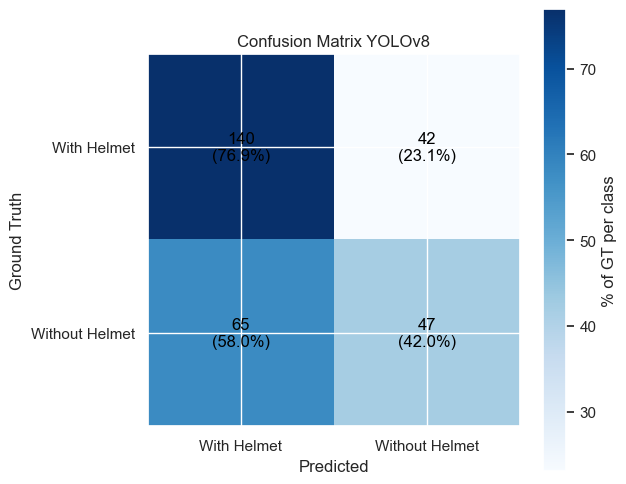

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- Cấu hình ---
model_path = "runs/detect/helmet_yolov8_nano14/weights/best.pt"
img_dir = "D:/study/thigiacmaytinh/btl/valid/images"
label_dir = "D:/study/thigiacmaytinh/btl/valid/labels"
class_names = ["With Helmet", "Without Helmet"]
num_classes = len(class_names)

# --- Load model ---
model = YOLO(model_path)

# --- Khởi tạo danh sách GT và Pred ---
y_true = []
y_pred = []

# Lấy danh sách ảnh validation
img_files = sorted(os.listdir(img_dir))

for img_file in img_files:
    # --- Ground truth ---
    gt_file = os.path.join(label_dir, img_file.replace(".jpg", ".txt"))
    if os.path.exists(gt_file):
        with open(gt_file) as f:
            lines = f.readlines()
            gt_classes = [int(line.split()[0]) for line in lines]
    else:
        gt_classes = []

    # --- Prediction ---
    results = model.predict(os.path.join(img_dir, img_file), imgsz=224, conf=0.25)  # conf có thể điều chỉnh
    pred_classes = [int(box.cls) for box in results[0].boxes]

    y_true.extend(gt_classes)
    y_pred.extend(pred_classes)

# --- Tạo confusion matrix ---
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

# --- Tính tỉ lệ phần trăm ---
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100
cm_percent = np.nan_to_num(cm_percent)  # tránh NaN khi dòng = 0

# --- Vẽ ma trận nhầm lẫn ---
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm_percent, cmap='Blues')

# Hiển thị số lượng và %
for i in range(num_classes):
    for j in range(num_classes):
        text = f"{cm[i,j]}\n({cm_percent[i,j]:.1f}%)"
        ax.text(j, i, text, ha='center', va='center', color='black', fontsize=12)

ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_xlabel("Predicted")
ax.set_ylabel("Ground Truth")
ax.set_title("Confusion Matrix YOLOv8")
plt.colorbar(im, label="% of GT per class")
plt.show()


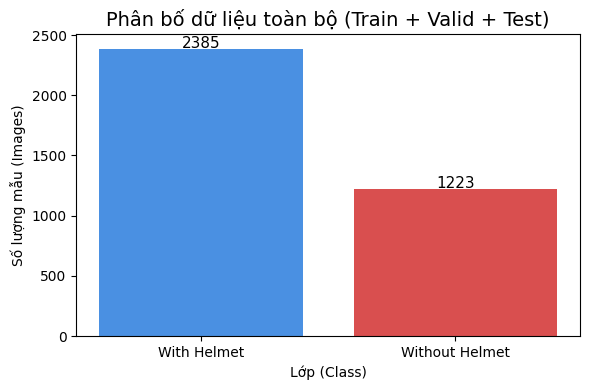

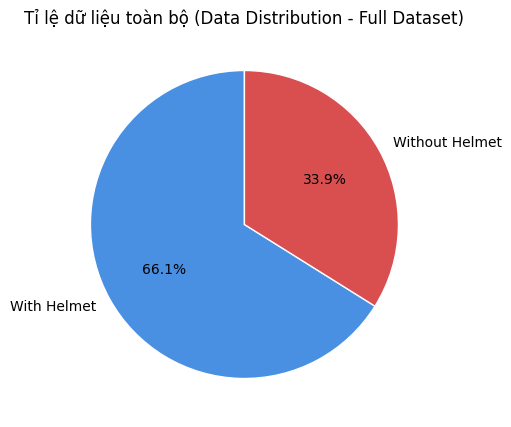

In [5]:
import os
import matplotlib.pyplot as plt

# --- Cấu hình ---
base_dir = "D:/study/thigiacmaytinh/btl"
splits = ["train", "valid", "test"]  # nếu không có test thì bỏ bớt
class_names = ["With Helmet", "Without Helmet"]
num_classes = len(class_names)

# --- Đếm số lượng mỗi lớp ---
class_counts_total = [0] * num_classes

for split in splits:
    label_dir = os.path.join(base_dir, split, "labels")
    if not os.path.exists(label_dir):
        continue
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                lines = f.readlines()
                for line in lines:
                    cls_id = int(line.split()[0])
                    class_counts_total[cls_id] += 1

# --- Vẽ biểu đồ ---
plt.figure(figsize=(6,4))
bars = plt.bar(class_names, class_counts_total, color=['#4a90e2', '#d94f4f'])
plt.title("Phân bố dữ liệu toàn bộ (Train + Valid + Test)", fontsize=14)
plt.xlabel("Lớp (Class)")
plt.ylabel("Số lượng mẫu (Images)")

# Hiển thị số trên cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             int(bar.get_height()), ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# --- Biểu đồ tròn ---
plt.figure(figsize=(5,5))
plt.pie(class_counts_total, labels=class_names, autopct='%1.1f%%',
        startangle=90, colors=['#4a90e2', '#d94f4f'], wedgeprops={'edgecolor': 'white'})
plt.title("Tỉ lệ dữ liệu toàn bộ (Data Distribution - Full Dataset)")
plt.show()


In [ ]:
import os
import cv2
import random
import time
from tqdm import tqdm
import albumentations as A

# ====== CẤU HÌNH ======
base_dir = "D:/study/thigiacmaytinh/btl"
train_img_dir = os.path.join(base_dir, "train/images")
train_label_dir = os.path.join(base_dir, "train/labels")
aug_img_dir = os.path.join(base_dir, "train_obj_aug/images")
aug_label_dir = os.path.join(base_dir, "train_obj_aug/labels")

os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)

class_names = ["With Helmet", "Without Helmet"]
target_class = 1                # lớp cần tăng (1 = Without Helmet)
target_add_objects = 1100       # 🔹 GIẢM XUỐNG CÒN 1100 OBJECT MUỐN THÊM

# ====== HÀM ĐẾM OBJECT TRONG THƯ MỤC ======
def count_objects_in_dir(label_dir, cls):
    cnt = 0
    if not os.path.isdir(label_dir):
        return 0
    for f in os.listdir(label_dir):
        if not f.endswith(".txt"):
            continue
        with open(os.path.join(label_dir, f)) as fh:
            for line in fh:
                try:
                    c = int(float(line.split()[0]))
                    if c == cls:
                        cnt += 1
                except:
                    continue
    return cnt

existing_aug = count_objects_in_dir(aug_label_dir, target_class)
print(f"Hiện có {existing_aug} object '{class_names[target_class]}' trong '{aug_label_dir}'")

need = target_add_objects - existing_aug
if need <= 0:
    print("✅ Đã đủ số object cần thêm. Không cần chạy augment.")
    raise SystemExit

print(f"⚙️ Cần tạo thêm {need} object '{class_names[target_class]}'")

# ====== LẤY DANH SÁCH ẢNH GỐC CÓ LỚP TARGET ======
files_with_target = []
for lf in os.listdir(train_label_dir):
    if not lf.endswith(".txt"):
        continue
    path = os.path.join(train_label_dir, lf)
    with open(path) as fh:
        if any(int(float(line.split()[0])) == target_class for line in fh if line.strip()):
            files_with_target.append(lf)

if not files_with_target:
    raise SystemExit("❌ Không tìm thấy ảnh chứa lớp target trong train/labels")

random.shuffle(files_with_target)

# ====== CẤU HÌNH AUGMENTATION ======
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.RandomGamma(p=0.3),
    A.CLAHE(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10, p=0.3),
    A.MotionBlur(p=0.1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# ====== SINH ẢNH MỚI ======
generated_objects = 0
global_idx = 0
tries_per_image = 5   # giảm số lần thử để nhanh hơn

print("\n🚀 Bắt đầu generate...")
file_index = 0
loop_iter = 0
max_loops = 5000
pbar = tqdm(total=need, desc="Creating objects")

while generated_objects < need and loop_iter < max_loops:
    loop_iter += 1
    lf = files_with_target[file_index]
    file_index = (file_index + 1) % len(files_with_target)

    label_path = os.path.join(train_label_dir, lf)
    img_path = os.path.join(train_img_dir, lf.replace(".txt", ".jpg"))
    if not os.path.exists(img_path):
        continue

    bboxes, class_labels = [], []
    with open(label_path) as fh:
        for line in fh:
            try:
                cls, x, y, w, h = map(float, line.split())
                if int(cls) == target_class:
                    bboxes.append([x, y, w, h])
                    class_labels.append(int(cls))
            except:
                continue

    if not bboxes:
        continue

    for attempt in range(tries_per_image):
        augmented = transform(image=cv2.imread(img_path), bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented["image"]
        aug_boxes = augmented["bboxes"]
        aug_labels = augmented["class_labels"]

        added = sum(1 for c in aug_labels if c == target_class)
        if added == 0:
            continue

        base = os.path.splitext(lf)[0]
        new_img_name = f"{base}_objaug_{int(time.time()*1000)}_{global_idx}.jpg"
        new_label_name = os.path.splitext(new_img_name)[0] + ".txt"

        cv2.imwrite(os.path.join(aug_img_dir, new_img_name), aug_img)
        with open(os.path.join(aug_label_dir, new_label_name), "w") as outf:
            for box, cls in zip(aug_boxes, aug_labels):
                outf.write(f"{int(cls)} " + " ".join(map(str, box)) + "\n")

        global_idx += 1
        generated_objects += added
        pbar.update(added)
        break

pbar.close()
print(f"\n✅ Hoàn tất: đã tạo thêm {generated_objects} object (mục tiêu: {need}).")


c:\Users\MY PC\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Hiện có 0 object 'Without Helmet' trong 'D:/study/thigiacmaytinh/btl\train_obj_aug/labels'
⚙️ Cần tạo thêm 1100 object 'Without Helmet'

🚀 Bắt đầu generate...


Creating objects: 100%|██████████| 1100/1100 [00:03<00:00, 291.88it/s]


✅ Hoàn tất: đã tạo thêm 1100 object (mục tiêu: 1100).


📊 Số lượng đối tượng trong train_obj_aug:
  With Helmet: 0
  Without Helmet: 1100


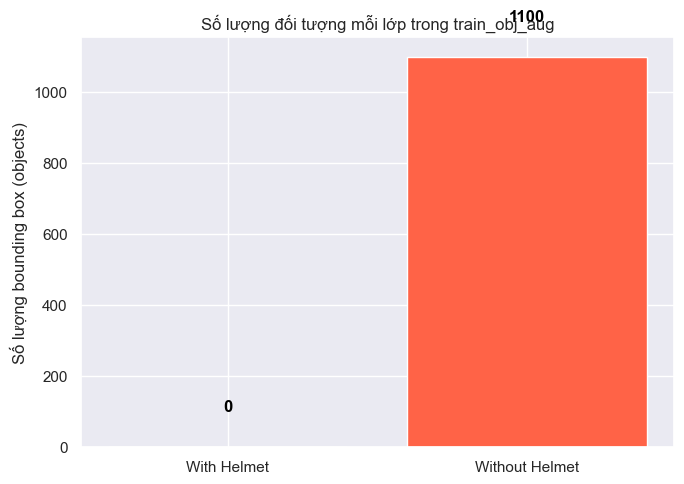

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# === CẤU HÌNH ===
base_dir = "D:/study/thigiacmaytinh/btl"
label_dir = os.path.join(base_dir, "train_obj_aug/labels")
class_names = ["With Helmet", "Without Helmet"]

# === ĐẾM BOUNDING BOX MỖI LỚP ===
class_counts = Counter()
for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_dir, label_file)) as f:
            for line in f:
                cls = int(float(line.split()[0]))  # sửa ở đây
                class_counts[cls] += 1

print("📊 Số lượng đối tượng trong train_obj_aug:")
for cls_id, name in enumerate(class_names):
    print(f"  {name}: {class_counts[cls_id]}")

# === VẼ BIỂU ĐỒ CỘT ===
plt.figure(figsize=(7,5))
plt.bar(class_names, [class_counts[0], class_counts[1]], color=['dodgerblue', 'tomato'])
for i, v in enumerate([class_counts[0], class_counts[1]]):
    plt.text(i, v + 100, str(v), ha='center', color='black', fontweight='bold')

plt.title("Số lượng đối tượng mỗi lớp trong train_obj_aug")
plt.ylabel("Số lượng bounding box (objects)")
plt.tight_layout()
plt.show()


In [ ]:
import shutil, os

base_dir = "D:/study/thigiacmaytinh/btl"
train_img_dir = os.path.join(base_dir, "train/images")
train_label_dir = os.path.join(base_dir, "train/labels")
aug_img_dir = os.path.join(base_dir, "train_obj_aug/images")
aug_label_dir = os.path.join(base_dir, "train_obj_aug/labels")

train_final_img = os.path.join(base_dir, "train_final/images")
train_final_label = os.path.join(base_dir, "train_final/labels")
os.makedirs(train_final_img, exist_ok=True)
os.makedirs(train_final_label, exist_ok=True)

# Gộp ảnh & label gốc
for src_dir in [train_img_dir, aug_img_dir]:
    for f in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, f), train_final_img)

for src_dir in [train_label_dir, aug_label_dir]:
    for f in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, f), train_final_label)

print("✅ Đã gộp train + train_obj_aug thành train_final/")


✅ Đã gộp train + train_obj_aug thành train_final/


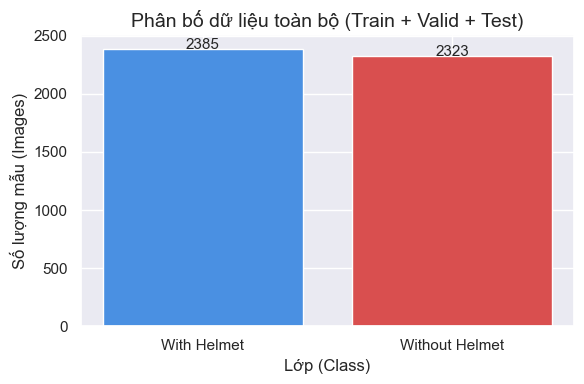

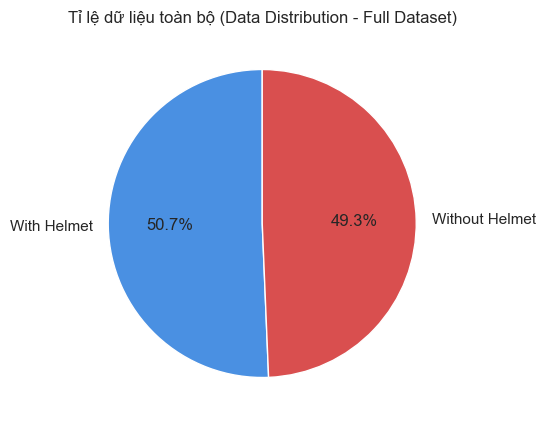

In [ ]:
import os
import matplotlib.pyplot as plt

# --- Cấu hình ---
base_dir = "D:/study/thigiacmaytinh/btl"
splits = ["train_final", "valid", "test"]  # nếu không có test thì bỏ bớt
class_names = ["With Helmet", "Without Helmet"]
num_classes = len(class_names)

# --- Đếm số lượng mỗi lớp ---
class_counts_total = [0] * num_classes

for split in splits:
    label_dir = os.path.join(base_dir, split, "labels")
    if not os.path.exists(label_dir):
        continue
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file)) as f:
                lines = f.readlines()
                for line in lines:
                    cls_id = int(line.split()[0])
                    class_counts_total[cls_id] += 1

# --- Vẽ biểu đồ ---
plt.figure(figsize=(6,4))
bars = plt.bar(class_names, class_counts_total, color=['#4a90e2', '#d94f4f'])
plt.title("Phân bố dữ liệu toàn bộ (Train + Valid + Test)", fontsize=14)
plt.xlabel("Lớp (Class)")
plt.ylabel("Số lượng mẫu (Images)")

# Hiển thị số trên cột
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             int(bar.get_height()), ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# --- Biểu đồ tròn ---
plt.figure(figsize=(5,5))
plt.pie(class_counts_total, labels=class_names, autopct='%1.1f%%',
        startangle=90, colors=['#4a90e2', '#d94f4f'], wedgeprops={'edgecolor': 'white'})
plt.title("Tỉ lệ dữ liệu toàn bộ (Data Distribution - Full Dataset)")
plt.show()


In [7]:
from ultralytics import YOLO
import torch
import ultralytics

# Cho phép DetectionModel được unpickle
torch.serialization.add_safe_globals([ultralytics.nn.tasks.DetectionModel])
model = YOLO("yolov8s.pt")  # hoặc yolov8n.pt nếu máy yếu
results = model.train(
    data="data.yaml",   # đúng tên file data
    epochs=30,          # giảm số epoch
    imgsz=320,      # giảm kích thước ảnh, ít tốn RAM/CPU
    batch=16,            # giảm batch size để vừa RAM
    name="helmet_yolov8_nano",
    device="cpu",       # chạy trên CPU
)

47

New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.204  Python-3.10.0 torch-2.5.1+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=helmet_yolov8_nano20, nbs=64, nms=False, ops

47

In [ ]:
from ultralytics import YOLO

# Load model đã train xong lần thử đầu tiên khi tinh chỉnh tham số
model = YOLO("runs/detect/helmet_yolov8_nano11/weights/best.pt")

# Evaluate trên dataset validation
metrics = model.val(data="data.yaml")

print(metrics)


Ultralytics YOLOv8.0.20  Python-3.10.0 torch-2.8.0+cpu CPU
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning D:\study\thigiacmaytinh\btl\valid\labels.cache... 126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\MY PC\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]
                   all        126        299       0.77      0.764      0.781      0.327
           With Helmet        126        184      0.841      0.788      0.801      0.355
        Without Helm

None


Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


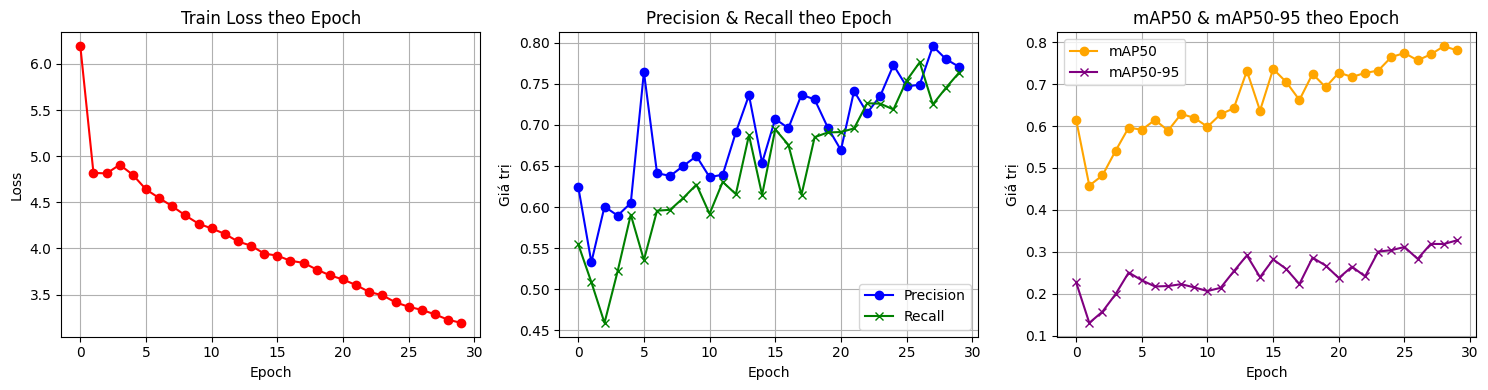

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Đường dẫn file CSV
csv_path = r"D:\study\thigiacmaytinh\btl\runs\detect\helmet_yolov8_nano11\results.csv"

# Đọc dữ liệu
df = pd.read_csv(csv_path)

# --- Xoá khoảng trắng ở đầu/cuối tên cột ---
df.columns = df.columns.str.strip()

# Kiểm tra lại tên cột
print(df.columns)

# Lấy dữ liệu sau khi strip
epochs = df['epoch']

# Tổng Loss train
train_loss = df['train/box_loss'] + df['train/cls_loss'] + df['train/dfl_loss']

# Precision, Recall, mAP
precision = df['metrics/precision(B)']
recall = df['metrics/recall(B)']
mAP50 = df['metrics/mAP50(B)']
mAP50_95 = df['metrics/mAP50-95(B)']

# --- Vẽ biểu đồ ---
plt.figure(figsize=(15, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, marker='o', color='red')
plt.title("Train Loss theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Precision & Recall
plt.subplot(1, 3, 2)
plt.plot(epochs, precision, marker='o', label="Precision", color='blue')
plt.plot(epochs, recall, marker='x', label="Recall", color='green')
plt.title("Precision & Recall theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)

# mAP50 & mAP50-95
plt.subplot(1, 3, 3)
plt.plot(epochs, mAP50, marker='o', label="mAP50", color='orange')
plt.plot(epochs, mAP50_95, marker='x', label="mAP50-95", color='purple')
plt.title("mAP50 & mAP50-95 theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
